In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import zipfile
import os
from tqdm import tqdm

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/plantvillage-dataset


In [3]:
path = "/kaggle/input/plantvillage-dataset/color"

In [4]:
# Loop through each class folder
for class_name in sorted(os.listdir(path)):
    class_path = os.path.join(path, class_name)
    if os.path.isdir(class_path):
        # Count only files (ignore subfolders, if any)
        image_count = sum(
            1 for file in os.listdir(class_path)
            if os.path.isfile(os.path.join(class_path, file))
        )
        print(f"{class_name}: {image_count} images")

Apple___Apple_scab: 630 images
Apple___Black_rot: 621 images
Apple___Cedar_apple_rust: 275 images
Apple___healthy: 1645 images
Blueberry___healthy: 1502 images
Cherry_(including_sour)___Powdery_mildew: 1052 images
Cherry_(including_sour)___healthy: 854 images
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 513 images
Corn_(maize)___Common_rust_: 1192 images
Corn_(maize)___Northern_Leaf_Blight: 985 images
Corn_(maize)___healthy: 1162 images
Grape___Black_rot: 1180 images
Grape___Esca_(Black_Measles): 1383 images
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1076 images
Grape___healthy: 423 images
Orange___Haunglongbing_(Citrus_greening): 5507 images
Peach___Bacterial_spot: 2297 images
Peach___healthy: 360 images
Pepper,_bell___Bacterial_spot: 997 images
Pepper,_bell___healthy: 1478 images
Potato___Early_blight: 1000 images
Potato___Late_blight: 1000 images
Potato___healthy: 152 images
Raspberry___healthy: 371 images
Soybean___healthy: 5090 images
Squash___Powdery_mildew: 1835 images
S

In [5]:
import os
import shutil
import random
from pathlib import Path

# Reproducibility (optional)
random.seed(42)

# Paths
source_dir = '/kaggle/input/plantvillage-dataset/color'
dest_dir   = '/kaggle/working/plantvillage-balanced'
min_required = 500

# Create destination directory
os.makedirs(dest_dir, exist_ok=True)

# Collect classes and counts
class_counts = {}
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if os.path.isdir(class_path):
        image_files = [f for f in os.listdir(class_path)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_counts[class_name] = len(image_files)

print("Found classes:", len(class_counts))
print("Counts per class:", class_counts)

# Build balanced dataset:
kept, skipped = [], []
for class_name, count in class_counts.items():
    src_class_path = os.path.join(source_dir, class_name)
    dst_class_path = os.path.join(dest_dir, class_name)

    # Skip classes with fewer than 350 images
    if count < min_required:
        skipped.append((class_name, count))
        continue

    os.makedirs(dst_class_path, exist_ok=True)

    # List image files and sample to exactly 350
    image_files = [f for f in os.listdir(src_class_path)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # If count == 350 this returns all, otherwise a downsample to 350
    sampled_files = random.sample(image_files, min_required)

    for filename in sampled_files:
        src = os.path.join(src_class_path, filename)
        dst = os.path.join(dst_class_path, filename)
        shutil.copy2(src, dst)

    kept.append((class_name, min_required))

print("\nSummary")
print("---------")
print(f"Kept classes (exactly {min_required} each): {len(kept)}")
for name, cnt in kept:
    print(f"  - {name}: {cnt}")

print(f"\nSkipped classes (< {min_required} images): {len(skipped)}")
for name, cnt in skipped:
    print(f"  - {name}: {cnt}")

print("\nBalanced dataset created at:", dest_dir)


Found classes: 38
Counts per class: {'Tomato___Late_blight': 1909, 'Tomato___healthy': 1591, 'Grape___healthy': 423, 'Orange___Haunglongbing_(Citrus_greening)': 5507, 'Soybean___healthy': 5090, 'Squash___Powdery_mildew': 1835, 'Potato___healthy': 152, 'Corn_(maize)___Northern_Leaf_Blight': 985, 'Tomato___Early_blight': 1000, 'Tomato___Septoria_leaf_spot': 1771, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 513, 'Strawberry___Leaf_scorch': 1109, 'Peach___healthy': 360, 'Apple___Apple_scab': 630, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 5357, 'Tomato___Bacterial_spot': 2127, 'Apple___Black_rot': 621, 'Blueberry___healthy': 1502, 'Cherry_(including_sour)___Powdery_mildew': 1052, 'Peach___Bacterial_spot': 2297, 'Apple___Cedar_apple_rust': 275, 'Tomato___Target_Spot': 1404, 'Pepper,_bell___healthy': 1478, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 1076, 'Potato___Late_blight': 1000, 'Tomato___Tomato_mosaic_virus': 373, 'Strawberry___healthy': 456, 'Apple___healthy': 1645, 'Grape

In [8]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),      # Resize and crop for augmentation
    transforms.RandomHorizontalFlip(),      # Augmentation
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load dataset
dataset = datasets.ImageFolder(root="/kaggle/working/plantvillage-balanced", transform=transform_train)
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Apply test transformation to validation and test sets

val_dataset.dataset.transform = transform_test
test_dataset.dataset.transform = transform_test

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = dataset.classes
num_classes = len(class_names)

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- 2D Self-Attention (Transformer-style on CNN feature maps) ---
class SelfAttention2D(nn.Module):

    def __init__(self, in_channels, d_model=256, num_heads=4, dropout=0.0):
        super().__init__()
        self.proj_in  = nn.Conv2d(in_channels, d_model, kernel_size=1)
        self.mha      = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads,
                                              dropout=dropout, batch_first=True)
        self.proj_out = nn.Conv2d(d_model, in_channels, kernel_size=1)
        self.norm1    = nn.LayerNorm(d_model)
        self.norm2    = nn.LayerNorm(d_model)
        self.ffn      = nn.Sequential(
            nn.Linear(d_model, 4*d_model),
            nn.GELU(),
            nn.Linear(4*d_model, d_model)
        )
        self.drop = nn.Dropout(dropout)

    def forward(self, x):  # x: [B, C, H, W]
        b, c, h, w = x.shape
        y = self.proj_in(x)                 # [B, d, H, W]
        y = y.flatten(2).transpose(1, 2)    # [B, HW, d]
        y = self.norm1(y)
        attn_out, _ = self.mha(y, y, y, need_weights=False)  # [B, HW, d]
        y = y + self.drop(attn_out)         # Residual 1
        y2 = self.ffn(self.norm2(y))
        y = y + self.drop(y2)               # Residual 2
        y = y.transpose(1, 2).view(b, -1, h, w)  # [B, d, H, W]
        y = self.proj_out(y)                # [B, C, H, W]
        return x + y                        # Final residual to keep C

# --- Example CNN with Self-Attention inserted after Block 3 ---
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2)   # 112x112 (for 224x224 input)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2)   # 56x56
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2)   # 28x28
        )

        # 🔑 Add attention when spatial map is reasonably small
        self.attn = SelfAttention2D(in_channels=128, d_model=256, num_heads=4, dropout=0.0)

        self.block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(2)   # 14x14
        )
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),   # [B, 256, 1, 1]
            nn.Flatten(),              # [B, 256]
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)   # [B, 32, 112, 112]
        x = self.block2(x)   # [B, 64, 56, 56]
        x = self.block3(x)   # [B, 128, 28, 28]
        x = self.attn(x)     # << Self-Attention >>
        x = self.block4(x)   # [B, 256, 14, 14]
        x = self.head(x)     # [B, num_classes]
        return x


In [28]:
import torch
import torch.nn as nn
import torchvision.models as models

class HybridModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # ResNet50
        self.model1 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        in_feats_resnet = self.model1.fc.in_features
        self.model1.fc = nn.Identity()

        # EfficientNet-B0
        self.model2 = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        in_feats_effnet = self.model2.classifier[1].in_features
        self.model2.classifier[1] = nn.Identity()

        # Combined classifier
        total_feats = in_feats_resnet + in_feats_effnet
        self.classifier = nn.Sequential(
            nn.Linear(total_feats, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # Extract features
        f1 = self.model1(x)  # ResNet50 features
        f2 = self.model2(x)  # EfficientNet-B0 features

        # Concatenate
        fused = torch.cat((f1, f2), dim=1)

        # Classify
        out = self.classifier(fused)
        return out


In [24]:
class EarlyStopping:

    def __init__(self, patience=5):

        self.patience = patience
        self.counter = 0
        self.best_loss = np.inf

    def check_early_stop(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


In [37]:


from tqdm import tqdm  # Import tqdm for progress bars
from torch.cuda.amp import autocast, GradScaler  # Import AMP utilities

# Set number of epochs and initialize variables

num_epochs = 50  # Define the number of training epochs

model = CustomCNN(num_classes=num_classes).to('cuda')  # Move model to GPU

criterion = nn.CrossEntropyLoss()  # Loss function

optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Optimizer with learning rate

early_stopping = EarlyStopping(patience=5)  # Initialize early stopping with patience

train_losses, val_losses = [], []  # Lists to store training and validation losses per epoch

# Initialize GradScaler for AMP
scaler = GradScaler()
# Loop over epochs
for epoch in range(num_epochs):

    print(f"Epoch {epoch+1}/{num_epochs}")
    # Training phase
    model.train()  # Set model to training mode
    train_loss = 0  # Initialize cumulative training loss for the epoch
    # Loop over training data with tqdm progress bar
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to('cuda'), labels.to('cuda')  # Move data to GPU
        optimizer.zero_grad()  # Clear previous gradients
        with autocast():  # Use AMP for mixed-precision calculations
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

        # Scale loss to avoid underflow for float16
        scaler.scale(loss).backward()  # Backward pass with scaled loss
        scaler.step(optimizer)  # Optimizer step
        scaler.update()  # Update the scaler for next iteration
        train_loss += loss.item()  # Accumulate the training loss

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0  # Initialize cumulative validation loss for the epoch
    with torch.no_grad():  # Disable gradient calculation for validation
        # Loop over validation data with tqdm progress bar
        for images, labels in tqdm(val_loader, desc="Validation", leave=False):
            images, labels = images.to('cuda'), labels.to('cuda')  # Move data to GPU
            with autocast():  # Use AMP for mixed-precision calculations
                outputs = model(images)  # Forward pass
                loss = criterion(outputs, labels)  # Compute loss
            val_loss += loss.item()  # Accumulate the validation loss

    # Calculate average losses and append to lists
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    # Early stopping check
    if early_stopping.check_early_stop(avg_val_loss):
        print("Early stopping triggered.")
        break



/tmp/ipykernel_36/1519950316.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/50


Training:   0%|          | 0/340 [00:00<?, ?it/s]/tmp/ipykernel_36/1519950316.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Use AMP for mixed-precision calculations
Validation:   0%|          | 0/97 [00:00<?, ?it/s]         /tmp/ipykernel_36/1519950316.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Use AMP for mixed-precision calculations


Train Loss: 1.9929, Validation Loss: 1.1849
Epoch 2/50


Train Loss: 1.0212, Validation Loss: 0.7608
Epoch 3/50


Train Loss: 0.6499, Validation Loss: 0.4944
Epoch 4/50


Train Loss: 0.4711, Validation Loss: 0.3546
Epoch 5/50


Train Loss: 0.3570, Validation Loss: 0.3053
Epoch 6/50


Train Loss: 0.2955, Validation Loss: 0.2438
Epoch 7/50


Train Loss: 0.2460, Validation Loss: 0.2129
Epoch 8/50


Train Loss: 0.2167, Validation Loss: 0.2237
Epoch 9/50


Train Loss: 0.2068, Validation Loss: 0.2087
Epoch 10/50


Train Loss: 0.1714, Validation Loss: 0.1512
Epoch 11/50


Train Loss: 0.1430, Validation Loss: 0.1724
Epoch 12/50


Train Loss: 0.1234, Validation Loss: 0.1721
Epoch 13/50


Train Loss: 0.1090, Validation Loss: 0.1818
Epoch 14/50


Train Loss: 0.1128, Validation Loss: 0.1684
Epoch 15/50


Train Loss: 0.0884, Validation Loss: 0.1409
Epoch 16/50


Train Loss: 0.0768, Validation Loss: 0.1382
Epoch 17/50


Train Loss: 0.0705, Validation Loss: 0.1255
Epoch 18/50


Train Loss: 0.0752, Validation Loss: 0.1332
Epoch 19/50


Train Loss: 0.0708, Validation Loss: 0.1298
Epoch 20/50


Train Loss: 0.0696, Validation Loss: 0.1319
Epoch 21/50


Train Loss: 0.0562, Validation Loss: 0.1334
Epoch 22/50


Train Loss: 0.0637, Validation Loss: 0.1190
Epoch 23/50


Train Loss: 0.0552, Validation Loss: 0.1445
Epoch 24/50


Train Loss: 0.0547, Validation Loss: 0.1170
Epoch 25/50


Train Loss: 0.0398, Validation Loss: 0.1608
Epoch 26/50


Train Loss: 0.0612, Validation Loss: 0.1253
Epoch 27/50


Train Loss: 0.0460, Validation Loss: 0.1480
Epoch 28/50


Train Loss: 0.0309, Validation Loss: 0.1194
Epoch 29/50


Train Loss: 0.0583, Validation Loss: 0.1674
Early stopping triggered.


In [38]:
# Define a path for saving the model
model_save_path = "custom_cnn_model.pth"  # You can specify a different path or filename

# Save the model after training completes or early stopping is triggered
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to custom_cnn_model.pth


In [39]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to('cuda'), labels.to('cuda')
        with autocast():
            outputs = model(images)
        preds = torch.argmax(outputs, dim=1)  # Get predicted class
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report
report = classification_report(all_labels, all_preds, digits=4)
print("Classification Report:\n", report)


/tmp/ipykernel_36/2132857589.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Classification Report:
               precision    recall  f1-score   support

           0     0.9262    0.9741    0.9496       116
           1     0.9375    1.0000    0.9677        90
           2     0.9072    0.9670    0.9362        91
           3     0.9574    0.9890    0.9730        91
           4     0.9573    0.9912    0.9739       113
           5     0.9630    0.9905    0.9765       105
           6     0.9524    0.8602    0.9040        93
           7     0.9919    1.0000    0.9960       123
           8     0.8359    0.9817    0.9030       109
           9     1.0000    1.0000    1.0000       107
          10     0.9529    0.9419    0.9474        86
          11     0.9579    0.9785    0.9681        93
          12     1.0000    0.9694    0.9845        98
          13     0.8725    0.9889    0.9271        90
          14     0.9195    0.9412    0.9302        85
          15     0.8333    0.9804    0.9009       102
          16     0.9881    0.9432    0.9651        88
   

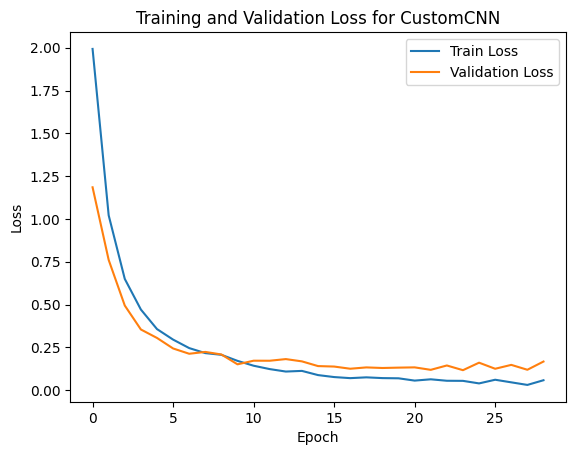

In [40]:
# Plotting loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss for CustomCNN")
plt.show()

/tmp/ipykernel_36/1808153850.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type=="cuda")):


Testing time: 4.97 sec  |  Throughput: 311.94 samples/sec
Confusion Matrix:
 [[39  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0 48  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0 41  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0 56  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0 50  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0 52  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 39  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 40  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 46  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 43  0  0  0 

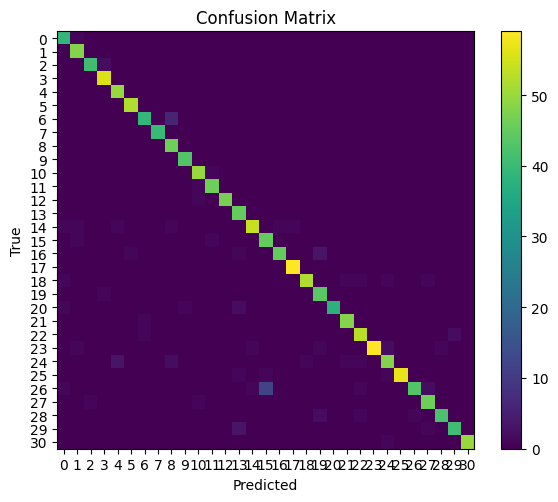

Per-class ROC AUC:
  Class 0: 0.9999
  Class 1: 1.0000
  Class 2: 0.9997
  Class 3: 1.0000
  Class 4: 1.0000
  Class 5: 1.0000
  Class 6: 0.9996
  Class 7: 1.0000
  Class 8: 0.9998
  Class 9: 1.0000
  Class 10: 0.9999
  Class 11: 0.9999
  Class 12: 1.0000
  Class 13: 0.9997
  Class 14: 0.9996
  Class 15: 0.9984
  Class 16: 0.9983
  Class 17: 1.0000
  Class 18: 0.9998
  Class 19: 0.9995
  Class 20: 1.0000
  Class 21: 1.0000
  Class 22: 0.9994
  Class 23: 0.9994
  Class 24: 0.9976
  Class 25: 0.9992
  Class 26: 0.9981
  Class 27: 0.9975
  Class 28: 0.9994
  Class 29: 0.9970
  Class 30: 1.0000
Micro-average ROC AUC: 0.9992
Macro-average ROC AUC: 0.9994


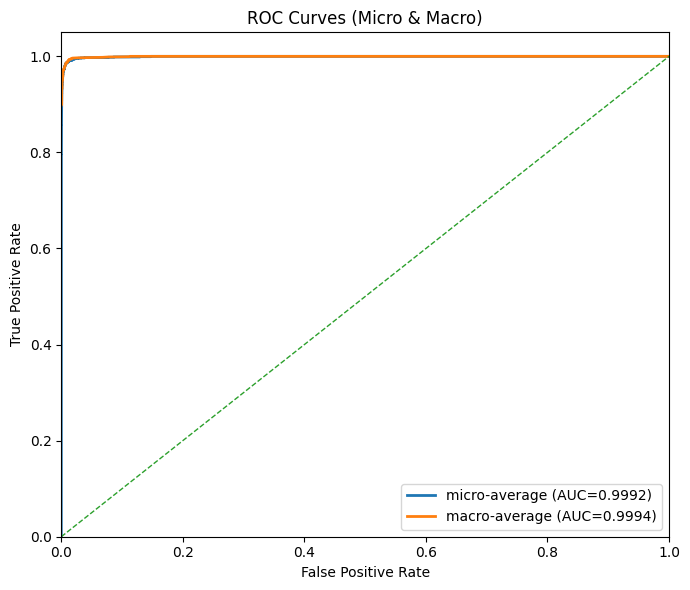

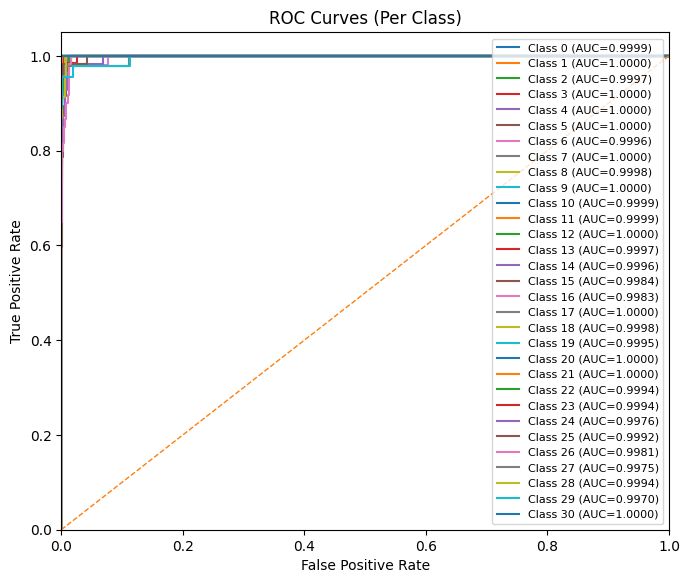


Classification Report (test):
              precision    recall  f1-score   support

           0     0.9070    0.9750    0.9398        40
           1     0.9231    1.0000    0.9600        48
           2     0.9762    0.9535    0.9647        43
           3     0.9492    1.0000    0.9739        56
           4     0.9259    1.0000    0.9615        50
           5     0.9811    1.0000    0.9905        52
           6     0.9512    0.8667    0.9070        45
           7     1.0000    1.0000    1.0000        40
           8     0.8364    1.0000    0.9109        46
           9     0.9773    1.0000    0.9885        43
          10     0.9434    0.9804    0.9615        51
          11     0.9583    0.9787    0.9684        47
          12     1.0000    0.9792    0.9895        48
          13     0.8654    1.0000    0.9278        45
          14     0.9643    0.9000    0.9310        60
          15     0.7759    0.9574    0.8571        47
          16     0.9783    0.9000    0.9375       

In [41]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torch.cuda.amp import autocast
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, roc_curve, auc, classification_report
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.eval()

all_logits   = []
all_probs    = []
all_preds    = []
all_labels   = []

# Use your real test loader here. If you only have val_loader, swap it in.
loader = test_loader  # <-- change to val_loader if that's what you actually use

t_test_start = time.time()
with torch.no_grad():
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        with autocast(enabled=(device.type=="cuda")):
            logits = model(images)                        # [B, C]
            probs  = F.softmax(logits, dim=1)            # [B, C]

        preds = torch.argmax(probs, dim=1)

        all_logits.append(logits.detach().cpu().numpy())
        all_probs.append(probs.detach().cpu().numpy())
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())

t_test_end = time.time()
total_test_time_sec = t_test_end - t_test_start
n_samples = len(all_preds)
print(f"Testing time: {total_test_time_sec:.2f} sec  |  Throughput: {n_samples/total_test_time_sec:.2f} samples/sec")
`
all_logits = np.concatenate(all_logits, axis=0)
all_probs  = np.concatenate(all_probs, axis=0)
all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)

num_classes = all_probs.shape[1]
class_indices = list(range(num_classes))

# ====== (C) CONFUSION MATRIX ======
cm = confusion_matrix(all_labels, all_preds, labels=class_indices)
print("Confusion Matrix:\n", cm)

# simple text view
def print_cm(cm):
    row_sums = cm.sum(axis=1, keepdims=True).clip(min=1)
    norm_cm = cm / row_sums
    print("\nConfusion Matrix (row-normalized):")
    with np.printoptions(precision=3, suppress=True):
        print(norm_cm)

print_cm(cm)

# Optional: plot CM (no seaborn)
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# ====== (D) ROC CURVES + AUC (handles binary or multiclass) ======
# For ROC/AUC we need one-vs-rest targets (binarized)
y_true_bin = label_binarize(all_labels, classes=class_indices) if num_classes > 2 else all_labels
y_score    = all_probs

if num_classes == 2:
    # Binary case: use positive class (class "1") for ROC
    fpr, tpr, _ = roc_curve(y_true_bin, y_score[:, 1])
    roc_auc = auc(fpr, tpr)
    print(f"Binary ROC AUC: {roc_auc:.4f}")

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Binary)')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

else:
    # Multiclass: compute per-class, micro, macro AUC
    # Per-class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for c in class_indices:
        fpr[c], tpr[c], _ = roc_curve(y_true_bin[:, c], y_score[:, c])
        roc_auc[c] = auc(fpr[c], tpr[c])

    # Micro-average
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Macro-average
    # First aggregate all FPRs
    all_fpr = np.unique(np.concatenate([fpr[c] for c in class_indices]))
    # Then interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(all_fpr)
    for c in class_indices:
        mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])
    mean_tpr /= num_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    print("Per-class ROC AUC:")
    for c in class_indices:
        print(f"  Class {c}: {roc_auc[c]:.4f}")
    print(f"Micro-average ROC AUC: {roc_auc['micro']:.4f}")
    print(f"Macro-average ROC AUC: {roc_auc['macro']:.4f}")

    # Plot micro & macro
    plt.figure(figsize=(7, 6))
    plt.plot(fpr["micro"], tpr["micro"], lw=2, label=f'micro-average (AUC={roc_auc["micro"]:.4f})')
    plt.plot(fpr["macro"], tpr["macro"], lw=2, label=f'macro-average (AUC={roc_auc["macro"]:.4f})')
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--')
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (Micro & Macro)')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    # (Optional) Plot per-class ROC (can be many curves)
    plt.figure(figsize=(7, 6))
    for c in class_indices:
        plt.plot(fpr[c], tpr[c], lw=1.5, label=f'Class {c} (AUC={roc_auc[c]:.4f})')
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--')
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (Per Class)')
    plt.legend(loc="lower right", fontsize=8)
    plt.tight_layout()
    plt.show()

# ====== (E) (Optional) Re-print classification report on test set ======
print("\nClassification Report (test):")
print(classification_report(all_labels, all_preds, digits=4))


In [34]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git


!pip install lime

  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-ez91g0k9
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-ez91g0k9
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 781dbc0d16ffa95b6d18b96b7b829840a82d93d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00:00:0100:01

In [35]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


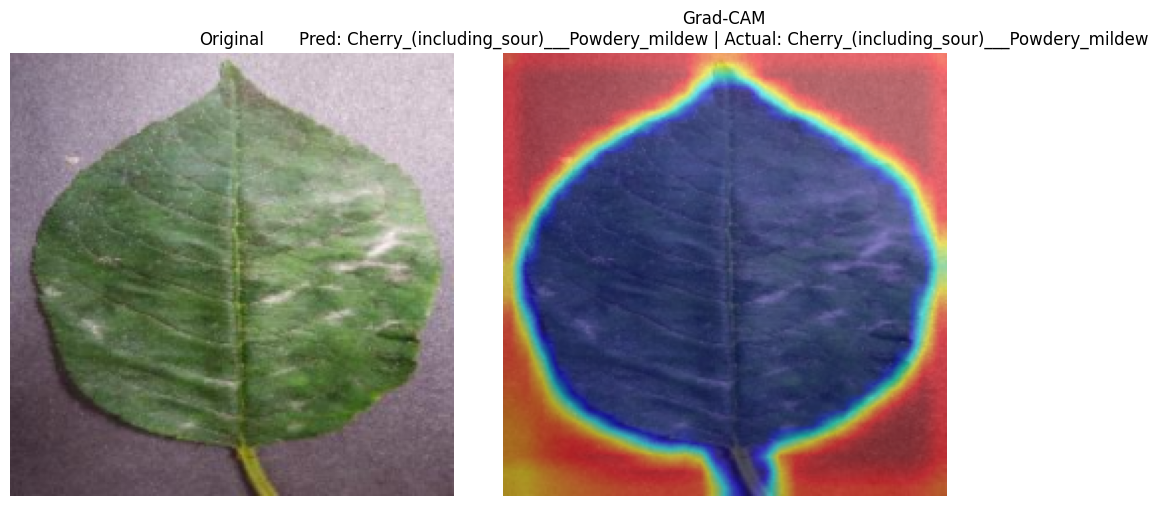

In [36]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt

# Ensure model is on GPU
model.eval().to('cuda')

# pick sample
sample_image, label = test_dataset[0]
sample_image = sample_image.unsqueeze(0).to('cuda')

# unnormalize for overlay (adjust mean/std if different)
original_image_np = sample_image.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
original_image_np = (original_image_np * 0.5) + 0.5
original_image_np = original_image_np.clip(0, 1)

# target layer: last conv before pooling
target_layers = [model.block4[0]]

# Create GradCAM object (no use_cuda argument)
cam = GradCAM(model=model, target_layers=target_layers)

# run inference to get predicted class
outputs = model(sample_image)
predicted_class = outputs.argmax(dim=1).item()

# define target for GradCAM
targets = [ClassifierOutputTarget(predicted_class)]

# generate cam
grayscale_cam = cam(input_tensor=sample_image, targets=targets, eigen_smooth=True)
heatmap = grayscale_cam[0]

# overlay heatmap
result = show_cam_on_image(original_image_np, heatmap, use_rgb=True)

# plot results
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.title("Original"); plt.imshow(original_image_np); plt.axis('off')
plt.subplot(1,2,2); plt.title(f"Grad-CAM\nPred: {class_names[predicted_class]} | Actual: {class_names[label]}"); 
plt.imshow(result); plt.axis('off')
plt.tight_layout(); plt.show()
